In [20]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns

# importation des modules
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.stats as sps
import mysql.connector as sql
from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform

# magic
import warnings

warnings.filterwarnings('ignore')

db_connection = sql.connect(host='mysql.ozna.me', user='pnr1', password='groupesaepnr1', database='PNR', port='3306')

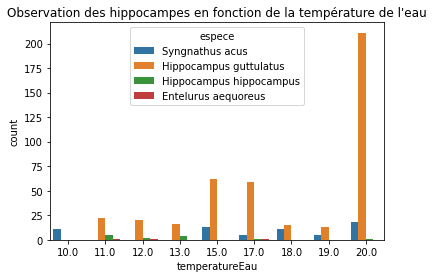

In [131]:
# 1 - Observation des hippocampes en fonction de la température de l'eau

attributs = "temperatureEau, espece"
df = pd.read_sql(f"SELECT {attributs} FROM Obs_Hippocampe JOIN Observation ON obsH = idObs", con=db_connection)

sns.countplot(x='temperatureEau', hue='espece', data=df)
plt.title("Observation des hippocampes en fonction de la température de l'eau")
print()


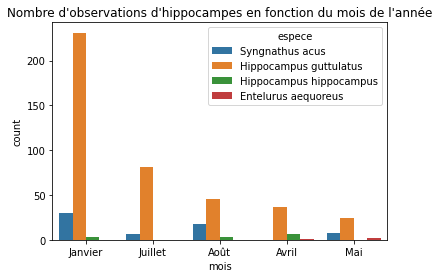

In [132]:
# 2 - Observation des hippocampes en fonction du mois de l'année

attributs = "MONTH(dateObs) mois, espece"
restriction = "temperatureEau IS NOT NULL"
df = pd.read_sql(f"SELECT {attributs} FROM Obs_Hippocampe JOIN Observation ON obsH = idObs WHERE {restriction}",
                 con=db_connection)

filter = {
    1: "Janvier",
    2: "Février",
    3: "Mars",
    4: "Avril",
    5: "Mai",
    6: "Juin",
    7: "Juillet",
    8: "Août",
    9: "Septembre",
    10: "Octobre",
    11: "Novembre",
    12: "Décembre"
}

sns.countplot(x='mois', hue='espece', data=df.replace(filter))
plt.title("Nombre d'observations d'hippocampes en fonction du mois de l'année")
print()


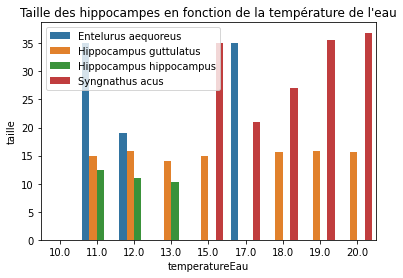

In [12]:
df = pd.read_sql("SELECT espece, temperatureEau, taille FROM Obs_Hippocampe", con=db_connection)
new_df = df.groupby(["espece", "temperatureEau"])[["taille"]].mean().reset_index()

sns.barplot(x='temperatureEau', y='taille', hue='espece', data=new_df)
plt.legend(loc='upper left')
plt.title("Taille des hippocampes en fonction de la température de l'eau")
print()

In [6]:
df = pd.read_sql(
    "SELECT idNid, MAX(dateObs)-MIN(dateObs), raisonArretObservation FROM Nid_GCI JOIN Obs_GCI ON idNid = leNid JOIN Observation ON idObs = obsG GROUP BY idNid;",
    con=db_connection)
df

,idNid,MAX(dateObs)-MIN(dateObs),raisonArretObservation
0,1,83,inconnu
1,2,83,inconnu
2,3,105,None
3,4,15,None
4,5,208,None
5,6,11,inconnu
6,7,184,None
7,8,10,inconnu
8,9,99,None
9,10,99,inconnu


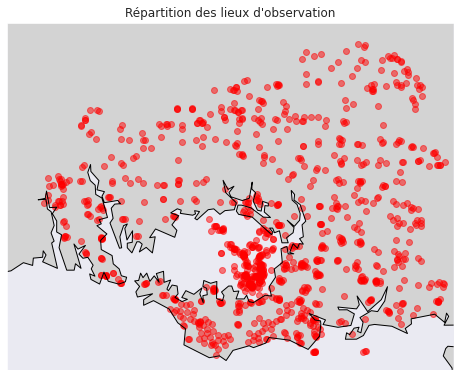

In [49]:
places = pd.read_sql("SELECT coord_Lambert_X, coord_Lambert_Y FROM Lieu", con=db_connection)
inProj = Proj(init='epsg:2154')
outProj = Proj(init='epsg:4326')

# Extract the data we're interested in
lat = places['coord_Lambert_X'].values
lon = places['coord_Lambert_Y'].values
places.dropna(inplace=True)

# Convert Lambert93 coordinates to GPS
for i in range(len(lat)):
    lon[i], lat[i] = transform(inProj, outProj, lat[i], lon[i])

# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h',
            lat_0=47.6335, lon_0=-2.7885,
            height=35E3, width=45E3)

m.drawcoastlines(color='black')
m.drawcountries(color='lightgray')
m.fillcontinents(color='lightgray')

# 2. Draw the points
m.scatter(lon, lat, latlon=True, c='red',
          cmap='Reds', alpha=0.5)

plt.title("Répartition des lieux d'observation")
plt.show()

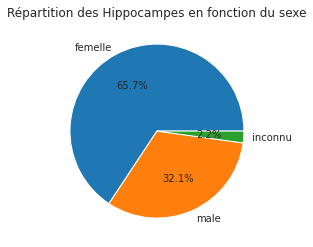

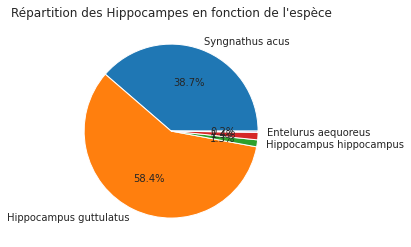

In [116]:
df = pd.read_sql("SELECT sexe, COUNT(*) nbIndividus FROM Obs_Hippocampe GROUP BY sexe", con=db_connection)
plt.pie(df['nbIndividus'], labels=df['sexe'], autopct='%1.1f%%')
plt.title("Répartition des Hippocampes en fonction du sexe")
plt.show()

df = pd.read_sql("SELECT espece, COUNT(*) nbIndividus FROM Obs_Hippocampe GROUP BY espece", con=db_connection)
plt.pie(df['nbIndividus'], labels=df['espece'], autopct='%1.1f%%')
plt.title("Répartition des Hippocampes en fonction de l'espèce")
plt.show()

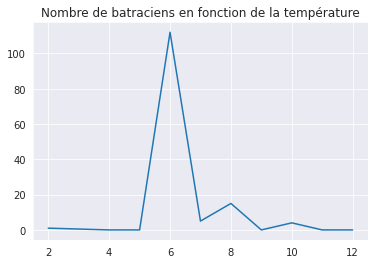

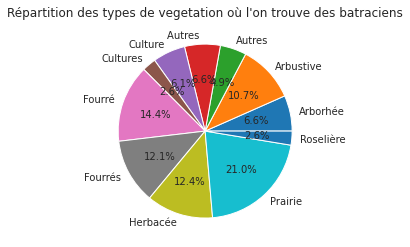

In [115]:
df = pd.read_sql("""SELECT temperature, SUM(nombreAdultes)
                    FROM Obs_Batracien
                    WHERE temperature IS NOT NULL
                    GROUP BY temperature
                    ORDER BY temperature;"""
                 , con=db_connection)
plt.plot(df['temperature'], df['SUM(nombreAdultes)'])
plt.title("Nombre de batraciens en fonction de la température")
plt.show()

df = pd.read_sql("SELECT * FROM Vegetation", con=db_connection)
df.dropna(inplace=True)
tmp = pd.DataFrame()
for s in df.values:
    for w in s[2].split(','):
        tmp = tmp.append({'vegetation': w, 'index': s[0]}, ignore_index=True)
tmp.groupby(['vegetation']).count()
plt.pie(tmp.groupby(['vegetation']).count()['index'], labels=tmp.groupby(['vegetation']).count()['index'].index, autopct='%1.1f%%')
plt.title("Répartition des types de vegetation où l'on trouve des batraciens")
plt.show()

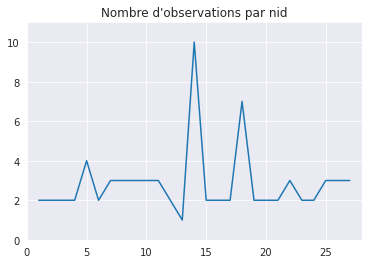

In [125]:
df = pd.read_sql("""SELECT idNid, COUNT(*) AS nbObs
                    FROM Nid_GCI
                    JOIN Obs_GCI OG on Nid_GCI.idNid = OG.leNid
                    GROUP BY idNid;"""
                 , con=db_connection)
plt.plot(df['idNid'], df['nbObs'])
plt.axis([0, df['idNid'].max() +1, 0, df['nbObs'].max() +1])
plt.title("Nombre d'observations par nid")
plt.show()

In [16]:
df = pd.read_sql(
    "SELECT idNid, MAX(dateObs)-MIN(dateObs), raisonArretObservation FROM Nid_GCI JOIN Obs_GCI ON idNid = leNid JOIN Observation ON idObs = obsG GROUP BY idNid;",
    con=db_connection)
df

,idNid,MAX(dateObs)-MIN(dateObs),raisonArretObservation
0,1,83,inconnu
1,2,83,inconnu
2,3,105,None
3,4,15,None
4,5,208,None
5,6,11,inconnu
6,7,184,None
7,8,10,inconnu
8,9,99,None
9,10,99,inconnu
